In [1]:
import torch
import random
import os
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score
import numpy as np
def wavelengthFilter(string):
    '''
    This function removes the um suffix from the wavelength data.

    Inputs
    ------
    string: A string to remove um from.

    Returns
    -------
    string: A float
    '''
    string=string.removesuffix(" um")
    return float(string)
def oneHotEncoding(combination):
    '''
    This function will turn molecule combinations into a one-hot encoded vector

    Inputs
    ------
    combination: Tuple containing the abundances of the molecules in this order: "O2","N2","H2","CO2","H2O","CH4","NH3"

    Returns
    -------
    vector: One-hot encoded vector of 1's and 0's
    '''

    #The order of the molecules are: "O2","N2","H2","CO2","H2O","CH4","NH3"
    vector=[0.]*7
    for i,abundance in enumerate(combination):
        #At what point should a molecule be considered present? I don't know need to think about that
        if abundance>0.001:
            vector[i]=1.0
    return torch.tensor(vector) 
def getLabel(filePath,specialMolecules=False):
    configFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles"
    # configFolder="/home/tristanb/scratch/configFiles"
    filePath=filePath.removesuffix(".csv")
    configFilePath=os.path.join(configFolder,filePath)
    configFilePath+=".txt"

    lines=[]
    with open(configFilePath) as f:
        for line in f:
            lines.append(line)


    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")
    
    if not specialMolecules:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
        label=oneHotEncoding(abundances)
        return label
    else:
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 
        label=oneHotEncoding(abundances)
        return label

class customDataset(Dataset):
    def __init__(self,samples):#samples contain a listt of all file paths
        self.samples=samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,index):
        filePath,label=self.samples[index]



        #Extract data from file
        data=pd.read_csv(filePath)
        wavelength=list(map(wavelengthFilter,data.iloc[:,0]))#Removes um from wavelength data
        transmittance=list(data.iloc[:,1])
        # if len(wavelength)!=784:
        #     print(filePath)
        # print(len(wavelength))
        combinedData=torch.tensor(list(zip(wavelength, transmittance)), dtype=torch.float32)
        # if torch.isnan(combinedData).any():
        #     print(filePath)
        return combinedData,label

class detectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv1d(in_channels=2, out_channels=128, kernel_size=5, stride=2)
        self.bn1=nn.BatchNorm1d(128)
        self.pool1=nn.MaxPool1d(2)

        self.conv2=nn.Conv1d(in_channels=128,out_channels=128,kernel_size=5,stride=2)
        self.bn2=nn.BatchNorm1d(128)
        self.pool2=nn.MaxPool1d(2)

        self.conv3=nn.Conv1d(in_channels=128,out_channels=64,kernel_size=3,stride=2)
        self.bn3=nn.BatchNorm1d(64)
        self.pool3=nn.MaxPool1d(2)

        self.conv4=nn.Conv1d(in_channels=64,out_channels=32,kernel_size=2,stride=2)
        self.bn4=nn.BatchNorm1d(32)
        self.pool4=nn.MaxPool1d(2)

        self.dropout1=nn.Dropout(0.4)

        self.global_pool = nn.AdaptiveAvgPool1d(1)



        self.fc1=nn.Linear(32,128)
        self.dropout2=nn.Dropout(0.75)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,7)#7 molecule present

    def forward(self,x):
        # Permute dimensions to [batch_size, channels, sequence_length]
        x=x.permute(0, 2, 1)
        x=F.relu(self.bn1(self.conv1(x)))
        x=self.pool1(x)

        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool2(x)

        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool3(x)

        x=F.relu(self.bn4(self.conv4(x)))
        x=self.pool4(x)

        x=self.dropout1(x)

        x=self.global_pool(x)
        x=torch.flatten(x,1)

        x=F.relu(self.fc1(x))
        x=self.dropout2(x)

        x=F.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))

        return x
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.fc_out = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()

        # Linear projections for Q, K, V
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Split into heads
        Q = Q.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)
        K = K.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)
        V = V.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)

        # Transpose to (batch, heads, seq_len, feature_dim)
        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-1, -2)) / (input_dim ** 0.5)
        attention_weights = self.softmax(scores)

        # Weighted sum of values
        weighted_sum = torch.matmul(attention_weights, V)

        # Concatenate heads and apply linear projection
        weighted_sum = weighted_sum.permute(0, 2, 1, 3).contiguous()
        weighted_sum = weighted_sum.view(batch_size, seq_length, input_dim)

        # Output linear layer
        out = self.fc_out(weighted_sum)

        return out, attention_weights


class abundanceModel(nn.Module):#CHange to output uncertainty as well
    def __init__(self):
        super().__init__()

        self.fcDetect=nn.Linear(7, 64)


        self.conv1=nn.Conv1d(in_channels=2, out_channels=256, kernel_size=5, stride=2)
        self.bn1=nn.BatchNorm1d(256)
        self.pool1=nn.MaxPool1d(2)

        self.conv2=nn.Conv1d(in_channels=256,out_channels=512,kernel_size=7,stride=1)
        self.bn2=nn.BatchNorm1d(512)
        self.pool2=nn.MaxPool1d(2)

        self.conv3=nn.Conv1d(in_channels=512,out_channels=256,kernel_size=5,stride=2)
        self.bn3=nn.BatchNorm1d(256)
        self.pool3=nn.MaxPool1d(2)

        self.conv4=nn.Conv1d(in_channels=256,out_channels=64,kernel_size=2,stride=2)
        self.bn4=nn.BatchNorm1d(64)
        self.pool4=nn.MaxPool1d(2)

        self.dropout1=nn.Dropout(0.329397809173006)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.attention=MultiHeadAttention(input_dim=64, num_heads=16)


        self.fc_combined=nn.Linear(128, 128)#Combines both input branches (detection + data)


        self.flatten=nn.Flatten()


        self.dropout2=nn.Dropout(0.502219550897328)
        self.fc2=nn.Linear(128,64)

        self.fc3=nn.Linear(64,32)
        self.fc4=nn.Linear(32,7)#7 molecule present

        #Another branch for uncertaintiy values for each molecule
        self.fc_uncertainty=nn.Linear(32,7)

    def forward(self,x,detectionOutput):

        detectionOutput=F.relu(self.fcDetect(detectionOutput))


        #Permute dimensions to [batch_size, channels, sequence_length]
        x=x.permute(0, 2, 1)
        x=F.relu(self.bn1(self.conv1(x)))
        x=self.pool1(x)

        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool2(x)

        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool3(x)

        x=F.relu(self.bn4(self.conv4(x)))
        x=self.pool4(x)


        x=self.dropout1(x)




        x=x.permute(0, 2, 1)
        x,attention_weights=self.attention(x)
        x=x.permute(0,2,1)
        x=self.global_pool(x)

        x=x.squeeze(-1)


        combined=torch.cat((x,detectionOutput), dim=1)
        combined=F.relu(self.fc_combined(combined))
        combined=F.relu(self.fc2(combined))
        combined=F.relu(self.fc3(combined))


        #Abundance branch
        logits=self.fc4(combined)
        #Apply softmax to make the output sum to 1 for abundances
        abundances=F.softmax(logits, dim=1)


        uncertaintyRaw=self.fc_uncertainty(combined)
        uncertainties=F.softplus(uncertaintyRaw)#Soft plus, since we don't want to bound to 1

        #In www.conf, found in etc php-fpm.d
        #listen = /tmp/run/php-fpm
        #And commented out listen.acl_gorups=apache,nginx
        #listen.moded=0666

        #Changed in etc/php-fpm.conf
        #Changed pid to equal /tmp/php-fpm.pid
        return abundances,uncertainties,attention_weights


random.seed(42)


testingData=[]


allSamples=[]
allLabels=[]
#

testSplit=0.15
for atmosphereType in ["A","B","C","None"]:
    print(atmosphereType)
    curFolderPath=r"C:\Users\Tristan\Downloads\HyPCAR3\data"
    curFolderPath+="\\"+atmosphereType
    files=[]
    for path in os.listdir(curFolderPath):

        if atmosphereType=="None":
            #Gett labels in a special way
            label=getLabel(path,True)
        else:

            label=getLabel(path)
        files.append((os.path.join(curFolderPath,path),label))
        

    random.shuffle(files)

    testingSamples=[]
    for i,data in enumerate(files):
        path,label=data[0],data[1]
        if i<(len(files)*testSplit):#Adds testing data
            testingSamples.append((path,label))
        else:
            break
            #Don't need more
    testingData.extend(testingSamples)

print("Data loaded")


random.shuffle(testingData)
testingDataset=customDataset(testingData)
testingDataloader=DataLoader(testingDataset,batch_size=32,shuffle=True)#Testing data loader

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
detect=detectionModel()
detect=detect.to(device)
detect.load_state_dict(torch.load(r"C:\Users\Tristan\Downloads\HyPCAR3\flexibleDetectionModel.pt",weights_only=True))

allPred=[]
allLabel=[]
for batch in testingDataloader:
    data,labels=batch
    data,labels=data.to(device),labels.to(device)

    with torch.no_grad():
        outputs=detect(data)
    preds = (outputs > 0.5)
    preds=preds.to(device)
    allLabel.append(labels)
    allPred.append(preds)

allLabel=np.concatenate([a.cpu().numpy() if hasattr(a, "cpu") else a for a in allLabel],axis=0)
allPred=np.concatenate([a.cpu().numpy() if hasattr(a, "cpu") else a for a in allPred],axis=0)


numMolecules=allLabel.shape[1]
balancedAcc=[]

for i in range(numMolecules):
    ba=balanced_accuracy_score(allLabel[:, i], allPred[:, i])
    balancedAcc.append(ba)

avgBalancedAcc=np.mean(balancedAcc)

print("Balanced accuracies per molecule:", balancedAcc)
print("Average balanced accuracy:", avgBalancedAcc)


A
B
C
None
Data loaded
Balanced accuracies per molecule: [0.9991478435961614, 0.9152882050015843, 0.7975477757244246, 0.998116830927751, 0.9954808658885641, 0.9970331202724512, 0.9987577557016261]
Average balanced accuracy: 0.9573389138732233


In [12]:
def oneHotEncoding(combination):
    '''
    This function will turn molecule combinations into a one-hot encoded vector

    Inputs
    ------
    combination: Tuple containing the abundances of the molecules in this order: "O2","N2","H2","CO2","H2O","CH4","NH3"

    Returns
    -------
    vector: One-hot encoded vector of 1's and 0's
    '''

    #The order of the molecules are: "O2","N2","H2","CO2","H2O","CH4","NH3"
    vector=[0.]*7
    for i,abundance in enumerate(combination):
        #At what point should a molecule be considered present? I don't know need to think about that
        if abundance>0.001:
            vector[i]=1.0
    return torch.tensor(vector) 
def getLabel(filePath,specialMolecules=False):
    configFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles"
    # configFolder="/home/tristanb/scratch/configFiles"
    filePath=filePath.removesuffix(".csv")
    configFilePath=os.path.join(configFolder,filePath)
    configFilePath+=".txt"

    lines=[]
    with open(configFilePath) as f:
        for line in f:
            lines.append(line)


    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")
    
    if not specialMolecules:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
        label=oneHotEncoding(abundances)
        return label
    else:
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 
        label=oneHotEncoding(abundances)
        return label

def getAbundances(fileName):
    '''
    This function grabs the molecule abundances from the config files and returns them as a vector

    Inputs
    ------
    fileName: The name of the config file.

    Returns
    -------
    abundances: A vector containing the abundance information
    '''
    configFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles"
    # configFolder="/home/tristanb/scratch/configFiles"
    fileName=fileName.removesuffix(".csv")
    configFilePath=os.path.join(configFolder,fileName)
    configFilePath+=".txt"

    abundances=[0.0]*7
    moleculeNames=["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]
    lines=[]
    with open(configFilePath) as f:
        for line in f:
            lines.append(line)

    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")

    if "None" in os.path.basename(fileName):
        #Special case
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 

    else:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
    return abundances



allData=[]
abundanceData=[]
for atmosphereType in ["A","B","C","None"]:
    curFolderPath=r"C:\Users\Tristan\Downloads\HyPCAR3\data\\"+atmosphereType


    for path in os.listdir(curFolderPath):
        #Need to get molecule abundances as well, this means that for each file, I need to go to the config file
        #Then extract the abundances there
        #This is how I will get the one-hot vector for the presence
        #Will just write a functionn
        if atmosphereType=="None":
            #Gett labels in a special way
            label=getLabel(path,True)
        else:
            label=getLabel(path)
        abundanceData.append(getAbundances(path))
        allData.append(label)
print(allData[0])
print(abundanceData[0])


tensor([0., 0., 1., 0., 1., 1., 1.])
[0.0, 0.0, 0.2772344370097009, 0.0, 0.13771633168201375, 0.4698620331291393, 0.11518719817914612]


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00917593e-08 0.00000000e+00 0.00000000e+00]


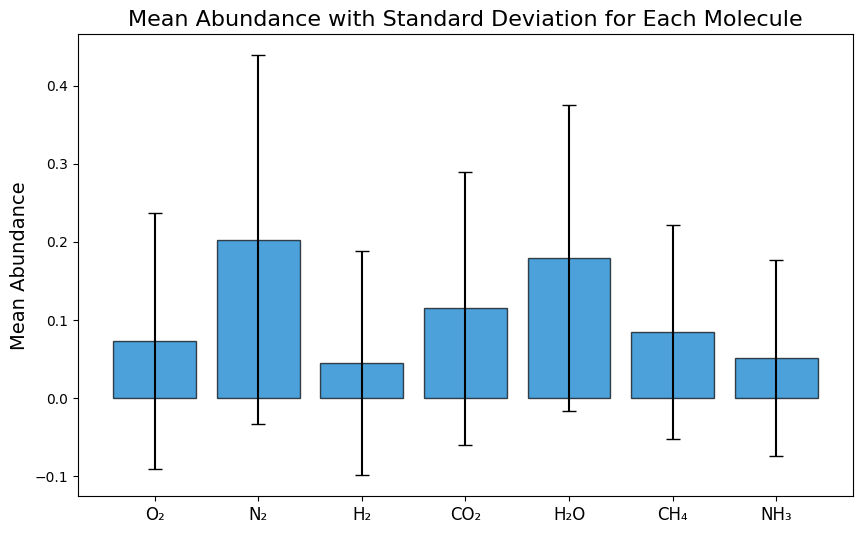

In [25]:
# stackedAbundances=torch.stack(abundanceData)
abundanceData=np.array(abundanceData)

molecule_names = ["O₂", "N₂", "H₂", "CO₂", "H₂O", "CH₄", "NH₃"]
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each molecule (column)
mean_abund = np.mean(abundanceData, axis=0)
std_abund = np.std(abundanceData, axis=0)
print(np.min(abundanceData,axis=0))
# X positions for the 7 molecules
x = np.arange(len(molecule_names))

plt.figure(figsize=(10, 6))
plt.bar(x, mean_abund, yerr=std_abund, color='#007ACC', alpha=0.7, 
        capsize=5, edgecolor='black')
plt.xticks(x, molecule_names, fontsize=12)
plt.ylabel("Mean Abundance", fontsize=14)
plt.title("Mean Abundance with Standard Deviation for Each Molecule", fontsize=16)
plt.show()

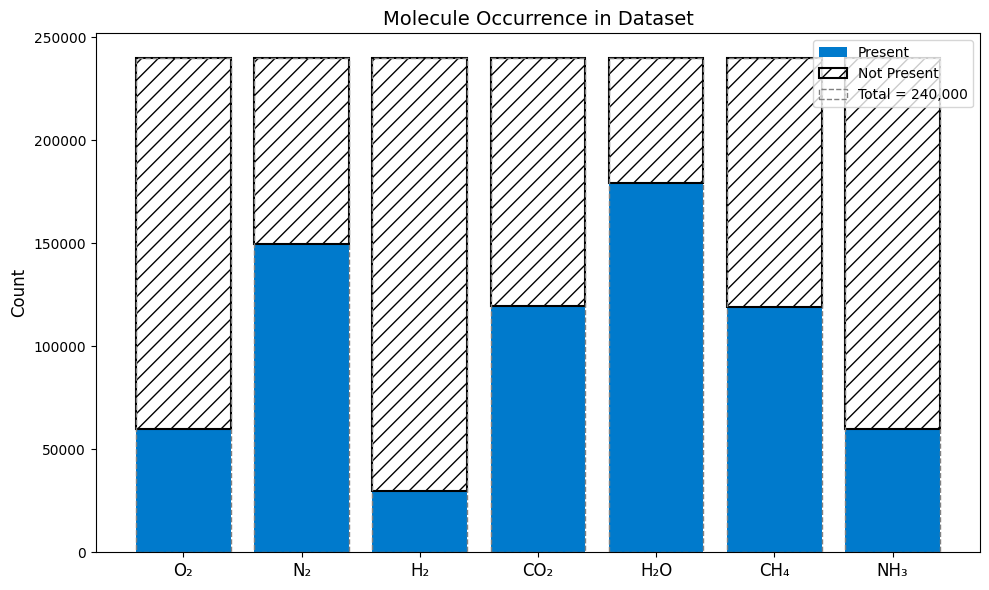

In [7]:

import matplotlib.pyplot as plt
import numpy as np

# Data for each molecule
molecule_names = ["O₂", "N₂", "H₂", "CO₂", "H₂O", "CH₄", "NH₃"]
present_counts = np.array([59864, 149701, 29949, 119580, 179479, 119310, 59742])
# not_present_counts are the counts of samples where the molecule is absent
not_present_counts = np.array([180136, 90299, 210051, 120420, 60521, 120690, 180258])
total_counts = present_counts + not_present_counts  # Should be 240,000 for each

# X positions for each molecule
x = np.arange(len(molecule_names))

plt.figure(figsize=(10, 6))

# Plot the "present" counts as a filled bar.
bar1 = plt.bar(x, present_counts, color='#007ACC', label="Present")

# Plot the "not present" counts on top of the filled bars. 
# Using bottom=present_counts makes this a stacked bar.
# The fill is set to "none" (transparent) while we draw an outline.
bar2 = plt.bar(x, not_present_counts, bottom=present_counts, 
               fill=False, edgecolor='black', linewidth=1.5, hatch='//',
               label="Not Present")

# Optional: Draw an outline around the full height so it's clear the total is 240k samples.
plt.bar(x, total_counts, fill=False, edgecolor='gray', linewidth=1.0, linestyle='--', label="Total = 240,000")

# Set the x-axis labels with molecule names
plt.xticks(x, molecule_names, fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Molecule Occurrence in Dataset", fontsize=14)

# Add a legend to explain the bars
plt.legend()

plt.tight_layout()
plt.show()



In [26]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd


def getAbundances(fileName):
    '''
    This function grabs the molecule abundances from the config files and returns them as a vector

    Inputs
    ------
    fileName: The name of the config file.

    Returns
    -------
    abundances: A vector containing the abundance information
    '''
    abundances=[0.0]*7
    moleculeNames=["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]
    lines=[]
    with open(fileName) as f:
        for line in f:
            lines.append(line)

    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")

    if "None" in os.path.basename(fileName):
        #Special case
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 

    else:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
    return abundances

configs=[file for file in os.listdir(r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles")]

sample=random.sample(configs,1)
dataFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\data"
configFolder=r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles"
for file in sample:
    baseName=os.path.basename(file)
    baseName=baseName.removesuffix(".txt")
    baseName+=".csv"
    folder=baseName.split("_")[0]
    if len(folder)==2:
        folder="A"
    elif len(folder)>1:
        folder="None"

    newPath=dataFolder+f"\\{folder}"
    newPath+=f"\\{baseName}"
    data=pd.read_csv(newPath)
    w,t=list(data.iloc[0:,0]),list(data.iloc[0:,1])
  
    with open("tempTransmittance.csv","w") as f:
        for i in range(len(w)):
            f.write(str(w[i][:-3])+","+str(t[i])+"\n")
    
    print(["O2","N2","H2","CO2","H2O","CH4","NH3"])
    print(getAbundances(os.path.join(configFolder,file)))
    print(newPath)



['O2', 'N2', 'H2', 'CO2', 'H2O', 'CH4', 'NH3']
[0.0, 0.3819293813457363, 0.0, 0.0, 0.33511101651338593, 0.2576119023030262, 0.0253476998378517]
C:\Users\Tristan\Downloads\HyPCAR3\data\A\A2_9933.csv


In [1]:
import numpy as np

# Data in percentages from the table
molecules = ["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]

# True values (using 0 for H2S as "Not Present")
true = np.array([20.9, 78.1, 0.03795, 0.35004, 0.000032, 0.00017, 0.0])

# Predictions from the normal model
normal = np.array([54.74, 7.28, 4.65, 26.18, 4.97, 0.08, 2.11])

# Predictions from the fine-tuned model
fine_tuned = np.array([38.7, 33.65, 27.64, 0.00097, 0.0096, 0.00019, 0.0032])

# Normalize distributions so that they sum to 1; note that the predicted values
# for both models already sum approximately to 100, but we do it explicitly.
p_true = true / true.sum()
p_normal = normal / normal.sum()
p_finetuned = fine_tuned / fine_tuned.sum()

def kl_divergence(p, q):
    """
    Computes KL divergence:  KL(p||q) = sum_i p[i] * log(p[i]/q[i])
    We add a small epsilon to avoid division or log of zero errors.
    """
    epsilon = 1e-12
    p_safe = np.maximum(p, epsilon)
    q_safe = np.maximum(q, epsilon)
    return np.sum(p_safe * np.log(p_safe / q_safe))

def cross_entropy(p, q):
    """
    Computes the cross entropy H(p,q) = -sum_i p[i] * log(q[i]).
    """
    epsilon = 1e-12
    q_safe = np.maximum(q, epsilon)
    return -np.sum(p * np.log(q_safe))

def mse(pred, true):
    """
    Computes the mean squared error between prediction and true values.
    """
    return np.mean((pred - true)**2)

# Compute KL divergence for both models (using the true distribution as p)
kl_normal = kl_divergence(p_true, p_normal)
kl_finetuned = kl_divergence(p_true, p_finetuned)

# Compute cross entropy for both models
ce_normal = cross_entropy(p_true, p_normal)
ce_finetuned = cross_entropy(p_true, p_finetuned)

# Compute MSE for both models using the raw percentages
mse_normal = mse(normal, true)
mse_finetuned = mse(fine_tuned, true)

print("KL Divergence:")
print(f"  Normal Model:     {kl_normal:.4f}")
print(f"  Fine-tuned Model: {kl_finetuned:.4f}\n")

print("Cross Entropy:")
print(f"  Normal Model:     {ce_normal:.4f}")
print(f"  Fine-tuned Model: {ce_finetuned:.4f}\n")

print("Mean Squared Error (MSE):")
print(f"  Normal Model:     {mse_normal:.4f}")
print(f"  Fine-tuned Model: {mse_finetuned:.4f}")

KL Divergence:
  Normal Model:     1.6513
  Fine-tuned Model: 0.5565

Cross Entropy:
  Normal Model:     2.1916
  Fine-tuned Model: 1.0967

Mean Squared Error (MSE):
  Normal Model:     982.6050
  Fine-tuned Model: 436.3768


In [28]:
import numpy as np

# Data in percentages from the table
molecules = ["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]

# True values (using 0 for H2S as "Not Present")
true = np.array([20.9, 78.1, 0.03795, 0.35004, 0.000032, 0.00017, 0.0])

# Predictions from the normal model
normal = np.array([57.269322872161865, 7.579978555440903, 20.22359073162079, 12.640121579170227, 1.5301313251256943, 0.039025183650664985, 0.717834709212184])

# Predictions from the fine-tuned model
fine_tuned = np.array([52.26215124130249, 8.5650734603405, 22.9727640748024, 13.6198952794075, 01.8039532005786896, 0.04164810525253415, 0.7345139980316162])

# Normalize distributions so that they sum to 1; note that the predicted values
# for both models already sum approximately to 100, but we do it explicitly.
p_true = true / true.sum()
p_normal = normal / normal.sum()
p_finetuned = fine_tuned / fine_tuned.sum()

def kl_divergence(p, q):
    """
    Computes KL divergence:  KL(p||q) = sum_i p[i] * log(p[i]/q[i])
    We add a small epsilon to avoid division or log of zero errors.
    """
    epsilon = 1e-12
    p_safe = np.maximum(p, epsilon)
    q_safe = np.maximum(q, epsilon)
    return np.sum(p_safe * np.log(p_safe / q_safe))

def cross_entropy(p, q):
    """
    Computes the cross entropy H(p,q) = -sum_i p[i] * log(q[i]).
    """
    epsilon = 1e-12
    q_safe = np.maximum(q, epsilon)
    return -np.sum(p * np.log(q_safe))

def mse(pred, true):
    """
    Computes the mean squared error between prediction and true values.
    """
    return np.mean((pred - true)**2)

# Compute KL divergence for both models (using the true distribution as p)
kl_normal = kl_divergence(p_true, p_normal)
kl_finetuned = kl_divergence(p_true, p_finetuned)

# Compute cross entropy for both models
ce_normal = cross_entropy(p_true, p_normal)
ce_finetuned = cross_entropy(p_true, p_finetuned)

# Compute MSE for both models using the raw percentages
mse_normal = mse(normal, true)
mse_finetuned = mse(fine_tuned, true)

print("KL Divergence:")
print(f"  Normal Model:     {kl_normal:.4f}")
print(f"  Fine-tuned Model: {kl_finetuned:.4f}\n")

print("Cross Entropy:")
print(f"  Normal Model:     {ce_normal:.4f}")
print(f"  Fine-tuned Model: {ce_finetuned:.4f}\n")

print("Mean Squared Error (MSE):")
print(f"  Normal Model:     {mse_normal:.4f}")
print(f"  Fine-tuned Model: {mse_finetuned:.4f}")

KL Divergence:
  Normal Model:     1.6120
  Fine-tuned Model: 1.5349

Cross Entropy:
  Normal Model:     2.1522
  Fine-tuned Model: 2.0752

Mean Squared Error (MSE):
  Normal Model:     979.5950
  Fine-tuned Model: 932.0830


In [12]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#MSE, KL, TOPK, CE
metrics=[0.016946299941168162,0.2659713218309528,0.5199267317939609,1.3270454406738281]

metrics=[a/sum(metrics) for a in metrics]
print(metrics)
metrics=np.array(metrics)
print(np.prod(metrics)**(1/len(metrics)))

print(len(metrics)/np.sum(1/metrics))



[0.007956421025631403, 0.12487562621796097, 0.24410968736507152, 0.6230582653913362]
0.11087337760644972
0.028695614105404537


In [1]:
import torch

# Load the entire model (make sure the model's class definition is available)
model = torch.load("bestBaseAbundance.pt",weights_only=True)

total_params = sum(param.numel() for param in model.values())
print("Total parameters:", total_params)


Total parameters: 1658098


In [3]:
import os
workingConfigFilePath=os.path.join("Temp/file/slurm/","workingDirectory/")+f"working-{1}.txt"
print(workingConfigFilePath)

Temp/file/slurm/workingDirectory/working-1.txt
